In [3]:
# standard modules
import sys
import os

# data and vizualisation models
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

# machine learning
import joblib
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.model_selection import cross_validate, learning_curve, train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor


# Get the current working directory
current_dir = os.getcwd()

# add 'main' to the path
main_dir = os.path.dirname(current_dir)
sys.path.append(main_dir)

# data preprocessing and scaling
from feature_engin.feature_import import combine_dataframes


Loaded coal_price.csv successfully.
Loaded ttf_price.csv successfully.
Loaded oil_price.csv successfully.
Loaded germany_electricity_generation_2018-2023.csv successfully.
Loaded holidays.csv successfully.
Loaded PMI_germany.csv successfully.
Loaded weather_north_hourly.csv successfully.
Loaded weather_south_hourly.csv successfully.
Loaded weather_brocken_hourly.csv successfully.


In [4]:
# fetching data
raw_data = combine_dataframes()


Loaded coal_price.csv successfully.
Loaded ttf_price.csv successfully.
Loaded oil_price.csv successfully.
Loaded germany_electricity_generation_2018-2023.csv successfully.
Loaded holidays.csv successfully.
Loaded PMI_germany.csv successfully.
Loaded weather_north_hourly.csv successfully.
Loaded weather_south_hourly.csv successfully.
Loaded weather_brocken_hourly.csv successfully.


In [20]:
# copying
data = raw_data.copy()
data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 199389 entries, 2018-01-02 00:00:00+00:00 to 2023-11-22 00:00:00+00:00
Data columns (total 45 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   coal_adj_close          199389 non-null  float64
 1   ttf_adj_close           199389 non-null  float64
 2   ttf_volume              199389 non-null  float64
 3   oil_adj_close           199389 non-null  float64
 4   oil_volume              199389 non-null  float64
 5   fractional_hour         199389 non-null  float64
 6   day_of_week             199389 non-null  float64
 7   week_of_year            199389 non-null  float64
 8   month                   199389 non-null  float64
 9   year                    199389 non-null  float64
 10  hydro_storage_in        199389 non-null  float64
 11  cross_border            199389 non-null  float64
 12  nuclear                 199389 non-null  float64
 13  hydro                   1993

In [28]:
# sortby the datetime index
data = data.sort_index()

# Identify the Split Point
split_date = data.index.max() - pd.Timedelta(weeks=2)

data_mod = data[data.index <= split_date]
last_two_weeks_data = data[data.index > split_date]

# Check the number of entries in the split datasets
print("Data up to the last two weeks:", data_mod.shape[0])
print("Last two weeks data:", last_two_weeks_data.shape[0])


Data up to the last two weeks: 198045
Last two weeks data: 1344


In [29]:
last_two_weeks_data.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1344 entries, 2023-11-08 00:15:00+00:00 to 2023-11-22 00:00:00+00:00
Data columns (total 45 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   coal_adj_close          1344 non-null   float64
 1   ttf_adj_close           1344 non-null   float64
 2   ttf_volume              1344 non-null   float64
 3   oil_adj_close           1344 non-null   float64
 4   oil_volume              1344 non-null   float64
 5   fractional_hour         1344 non-null   float64
 6   day_of_week             1344 non-null   float64
 7   week_of_year            1344 non-null   float64
 8   month                   1344 non-null   float64
 9   year                    1344 non-null   float64
 10  hydro_storage_in        1344 non-null   float64
 11  cross_border            1344 non-null   float64
 12  nuclear                 1344 non-null   float64
 13  hydro                   1344 non-null   float

In [30]:
# Display all column names from the dataset
column_names = data.columns.tolist()
column_names


['coal_adj_close',
 'ttf_adj_close',
 'ttf_volume',
 'oil_adj_close',
 'oil_volume',
 'fractional_hour',
 'day_of_week',
 'week_of_year',
 'month',
 'year',
 'hydro_storage_in',
 'cross_border',
 'nuclear',
 'hydro',
 'biomass',
 'lignite',
 'hard_coal',
 'oil',
 'coal_gas',
 'nat_gas',
 'geothermal',
 'hydro_reservoir',
 'hydro_storage_out',
 'others',
 'waste',
 'wind_offshore',
 'wind_onshore',
 'solar',
 'load',
 'residual_load',
 'renewable_share_gen',
 'renewable_share_load',
 'day_ahead_price',
 'holiday',
 'actual_pmi',
 'temp_north',
 'windspeed_north',
 'temp_south',
 'windspeed_south',
 'solarradiation_south',
 'solarenergy_south',
 'temp_brocken',
 'windspeed_brocken',
 'solarradiation_brocken',
 'solarenergy_brocken']

In [31]:
from sklearn.model_selection import train_test_split

# Separating the features and the target variable from the original dataset
X = data_mod.drop(columns=['day_ahead_price'])
y = data_mod['day_ahead_price']

# Splitting the data into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [32]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.compose import ColumnTransformer

# Features for MinMaxScaler and RobustScaler as defined by the user
features_min_max_scaler = ['coal_adj_close', 'ttf_adj_close', 'ttf_volume', 'oil_adj_close', 'oil_volume', "actual_pmi"]
features_robust_scaler = ['windspeed_north', 'windspeed_south', 'windspeed_brocken']

# Remaining features for StandardScaler, excluding the 'Unnamed: 0' column
features_standard_scaler = [col for col in data.columns if col not in features_min_max_scaler + features_robust_scaler + ['Unnamed: 0', 'day_ahead_price']]

# Redefining the scalers and transformers with the adjusted feature lists
standard_scaler_transformer = Pipeline(steps=[
    ('standard_scaler', StandardScaler())
])

min_max_scaler_transformer = Pipeline(steps=[
    ('min_max_scaler', MinMaxScaler())
])

robust_scaler_transformer = Pipeline(steps=[
    ('robust_scaler', RobustScaler())
])

# Combining the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('std_scaler', standard_scaler_transformer, features_standard_scaler),
        ('minmax_scaler', min_max_scaler_transformer, features_min_max_scaler),
        ('robust_scaler', robust_scaler_transformer, features_robust_scaler)
    ],
    remainder='passthrough'  # Non-scaled columns are passed through
)


In [33]:
# Applying the scaling pipeline separately to the training and testing sets
X_train_scaled = preprocessor.fit_transform(X_train)
X_test_scaled = preprocessor.transform(X_test)


In [34]:
# Code for training the model on the scaled training data
gbr = GradientBoostingRegressor(random_state=42)
gbr.fit(X_train_scaled, y_train)


GradientBoostingRegressor(random_state=42)

In [35]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np


# Predicting the target values for the test set
y_pred = gbr.predict(X_test_scaled)

# Calculating the metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Absolute Error: 12.09968579603216
Mean Squared Error: 422.9471275694283
R² Score: 0.9576947748499373


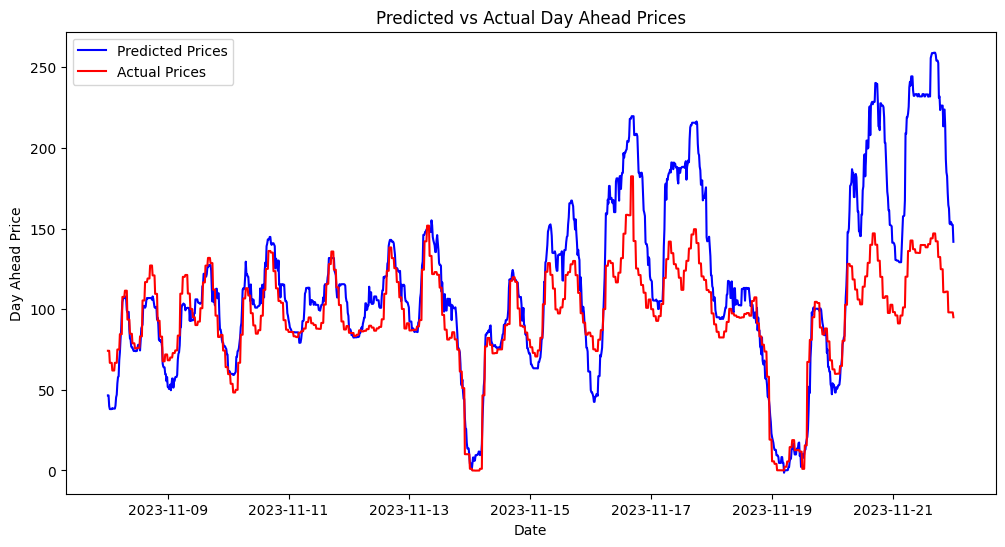

In [37]:
import matplotlib.pyplot as plt

# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices = gbr.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices, label='Predicted Prices', color='blue')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()
plt.show()


# Grid search

In [38]:
from sklearn.model_selection import GridSearchCV

# Defining the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5],
    # You can add more parameters here
}

# Setting up the GridSearchCV
gbr = GradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(estimator=gbr, param_grid=param_grid, cv=5, n_jobs=-1, verbose=3)

# Fitting GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Best parameters
best_parameters = grid_search.best_params_

# Train the model using the best parameters
best_gbr = GradientBoostingRegressor(**best_parameters, random_state=42)
best_gbr.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.500 total time= 3.2min
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.502 total time= 3.2min
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.506 total time= 3.2min
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.501 total time= 3.4min
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=50;, score=0.507 total time= 3.6min
[CV 2/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.721 total time= 7.3min
[CV 3/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.715 total time= 8.1min
[CV 1/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.723 total time= 8.2min
[CV 5/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.719 total time= 7.5min
[CV 4/5] END learning_rate=0.01, max_depth=3, n_estimators=100;, score=0.716 to

GradientBoostingRegressor(learning_rate=0.2, max_depth=5, n_estimators=200,
                          random_state=42)

In [39]:
# Accessing the best parameters
best_parameters = grid_search.best_params_

# Displaying the best parameters
print("Best Parameters Found:")
for param, value in best_parameters.items():
    print(f"{param}: {value}")


Best Parameters Found:
learning_rate: 0.2
max_depth: 5
n_estimators: 200


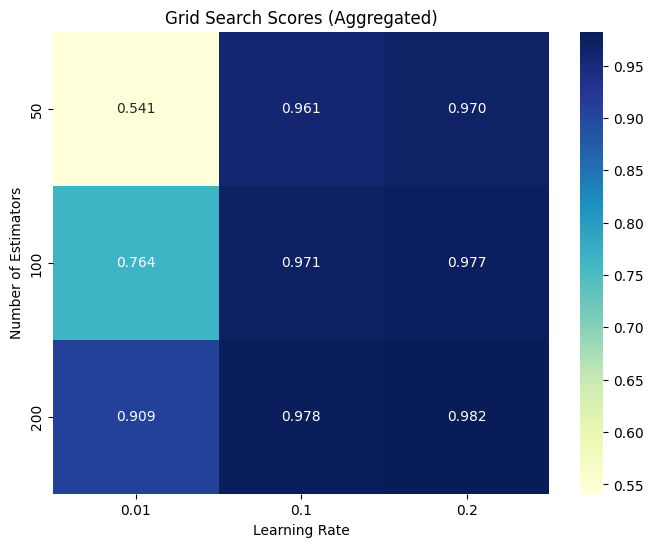

In [41]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the grid search results into a DataFrame
results = pd.DataFrame(grid_search.cv_results_)

# Aggregating the results
agg_results = results.groupby(['param_n_estimators', 'param_learning_rate']).agg({'mean_test_score': 'mean'}).reset_index()

# Creating the pivot table for the heatmap
pivot_table = agg_results.pivot(index='param_n_estimators', columns='param_learning_rate', values='mean_test_score')

# Plotting the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(pivot_table, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Grid Search Scores (Aggregated)')
plt.xlabel('Learning Rate')
plt.ylabel('Number of Estimators')
plt.show()


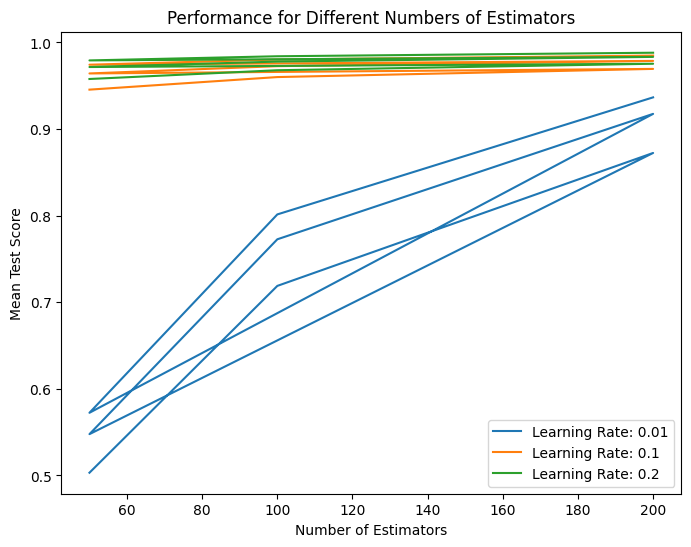

In [42]:
# Example for plotting performance against 'n_estimators'
plt.figure(figsize=(8, 6))
for learning_rate in results['param_learning_rate'].unique():
    subset = results[results['param_learning_rate'] == learning_rate]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], label=f'Learning Rate: {learning_rate}')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Performance for Different Numbers of Estimators')
plt.legend()
plt.show()


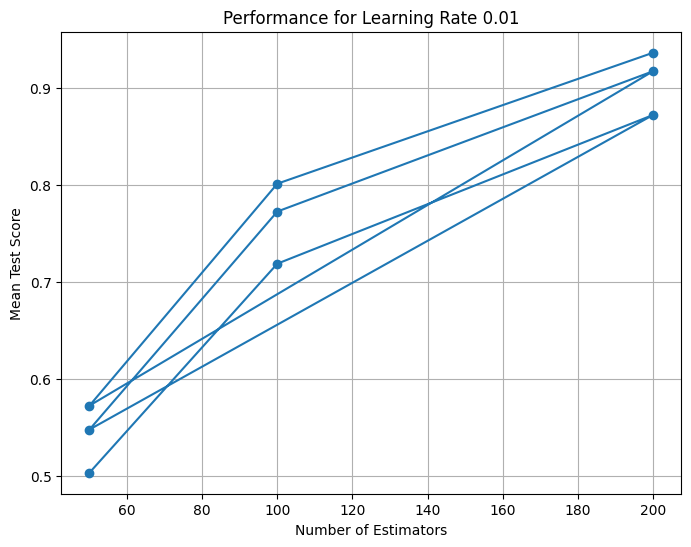

In [43]:
import matplotlib.pyplot as plt

# Filter the results for a learning rate of 0.01
lr_001_results = results[results['param_learning_rate'] == 0.01]

# Plotting performance against 'n_estimators'
plt.figure(figsize=(8, 6))
plt.plot(lr_001_results['param_n_estimators'], lr_001_results['mean_test_score'], marker='o')
plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Performance for Learning Rate 0.01')
plt.grid(True)
plt.show()


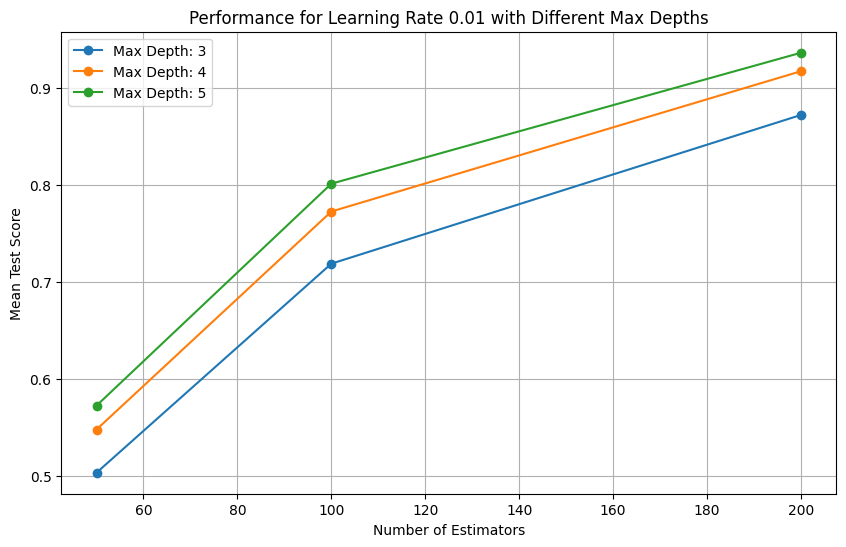

In [44]:
import matplotlib.pyplot as plt

# Filter the results for a learning rate of 0.01
lr_001_results = results[results['param_learning_rate'] == 0.01]

# Get unique values of max_depth
unique_max_depths = lr_001_results['param_max_depth'].unique()

plt.figure(figsize=(10, 6))

# Plotting performance for each max_depth
for max_depth in unique_max_depths:
    subset = lr_001_results[lr_001_results['param_max_depth'] == max_depth]
    plt.plot(subset['param_n_estimators'], subset['mean_test_score'], marker='o', label=f'Max Depth: {max_depth}')

plt.xlabel('Number of Estimators')
plt.ylabel('Mean Test Score')
plt.title('Performance for Learning Rate 0.01 with Different Max Depths')
plt.legend()
plt.grid(True)
plt.show()


# Choose best paramaters

In [46]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initializing the Gradient Boosting Regressor with specified hyperparameters
gbr_specific = GradientBoostingRegressor(n_estimators=200, learning_rate=0.01, max_depth=5, random_state=42)

# Training the model on the scaled training data
gbr_specific.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred = gbr_specific.predict(X_test_scaled)

# Evaluating the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Displaying the evaluation metrics
print("Mean Absolute Error:", mae)
print("Mean Squared Error:", mse)
print("R² Score:", r2)


Mean Absolute Error: 15.421428143433337
Mean Squared Error: 648.2559008929595
R² Score: 0.9351582974455085


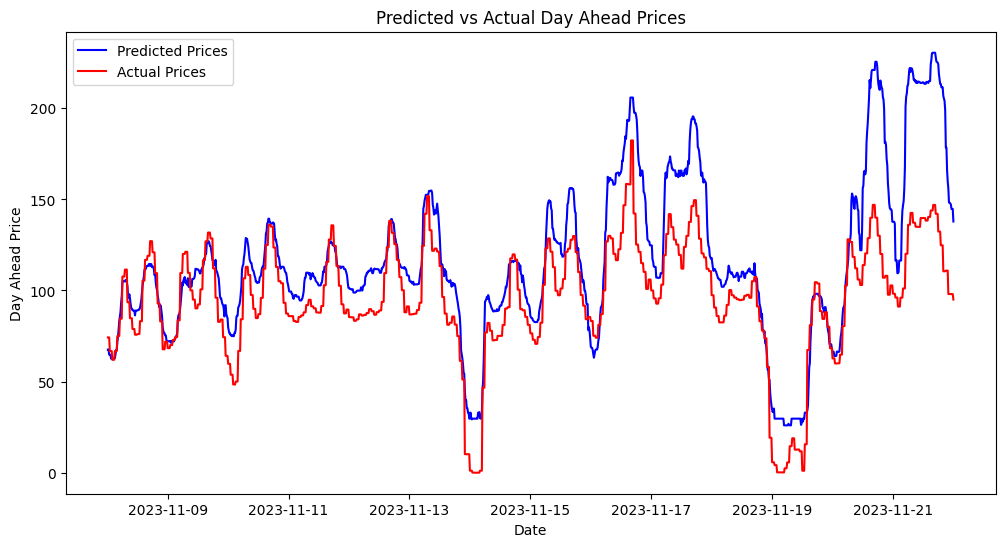

In [47]:
import matplotlib.pyplot as plt

# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_specific = gbr_specific.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_specific, label='Predicted Prices', color='blue')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()
plt.show()


In [48]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initializing the Gradient Boosting Regressor with the best parameters
gbr_best = GradientBoostingRegressor(n_estimators=200, learning_rate=0.2, max_depth=5, random_state=42)

# Training the model on the scaled training data
gbr_best.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred_best = gbr_best.predict(X_test_scaled)

# Evaluating the model
mae_best = mean_absolute_error(y_test, y_pred_best)
mse_best = mean_squared_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# Displaying the evaluation metrics
print("Mean Absolute Error:", mae_best)
print("Mean Squared Error:", mse_best)
print("R² Score:", r2_best)


Mean Absolute Error: 6.7664995017288385
Mean Squared Error: 122.26765733414385
R² Score: 0.9877701952917446


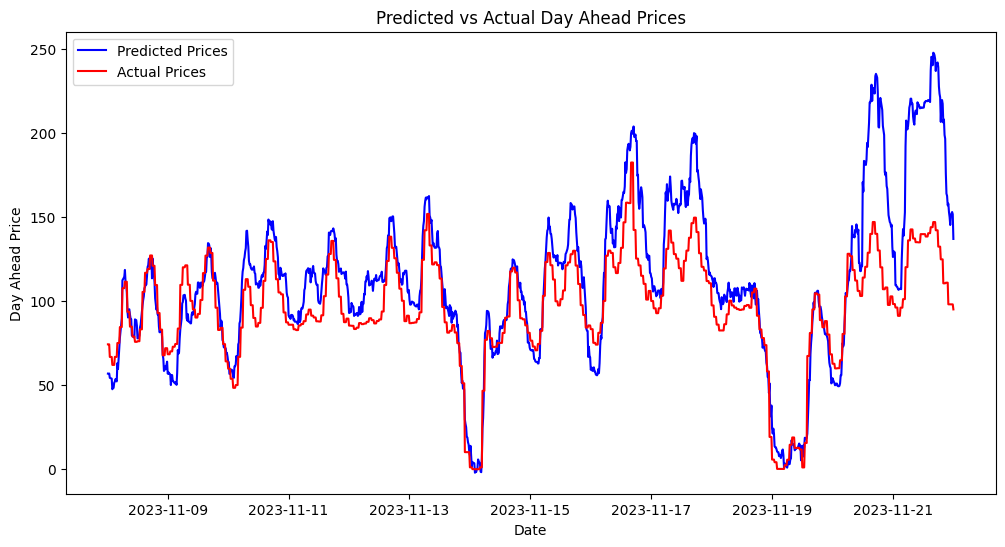

In [49]:
import matplotlib.pyplot as plt

# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_best= gbr_best.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_best, label='Predicted Prices', color='blue')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()
plt.show()


# Elastic Net Regressor (ENR)

In [51]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Initializing the Elastic Net Regressor
enr = ElasticNet(random_state=42)

# Training the model on the scaled training data
enr.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred_enr = enr.predict(X_test_scaled)

# Evaluating the model
mae_enr = mean_absolute_error(y_test, y_pred_enr)
mse_enr = mean_squared_error(y_test, y_pred_enr)
r2_enr = r2_score(y_test, y_pred_enr)

# Displaying the evaluation metrics
print("Mean Absolute Error:", mae_enr)
print("Mean Squared Error:", mse_enr)
print("R² Score:", r2_enr)


Mean Absolute Error: 41.97177481949621
Mean Squared Error: 4770.1468361399
R² Score: 0.5228667539097271


# Back to GBR model

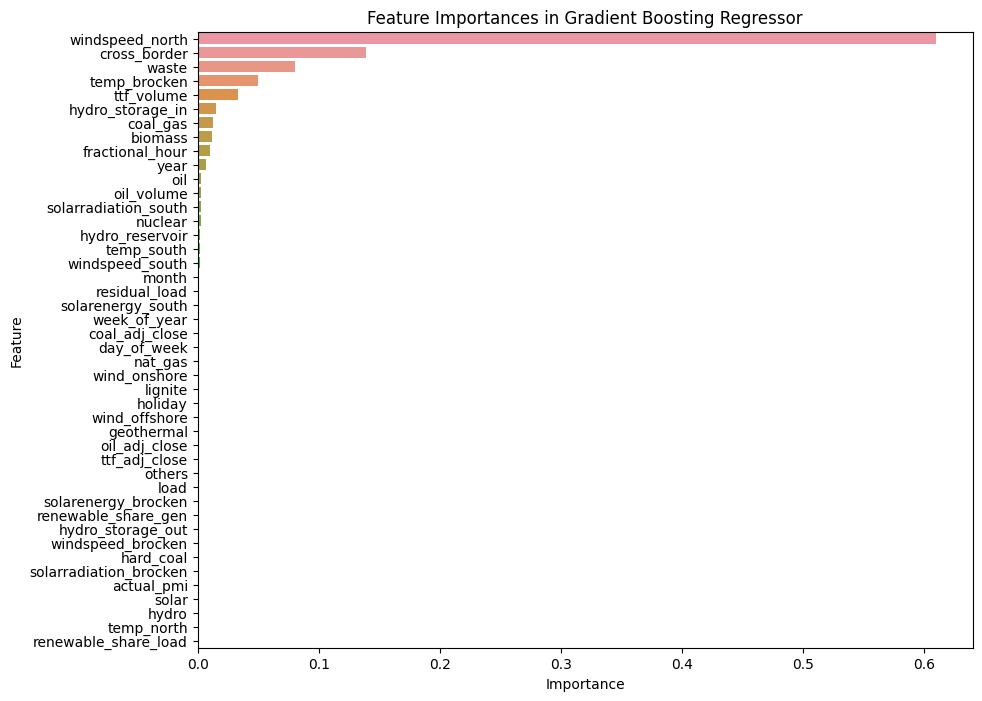

In [57]:
# Retrieve feature importances from the model
feature_importances = gbr_best.feature_importances_

# Assuming 'X_train' is your original training data DataFrame before scaling
feature_names = X_train.columns  # Get the feature names

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sorting the features based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plotting feature importances
plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances in Gradient Boosting Regressor')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [58]:
# Retrieve feature importances from the model
feature_importances = gbr_best.feature_importances_

# Assuming 'X_train' is your original training data DataFrame before scaling
feature_names = X_train.columns  # Get the feature names

# Create a DataFrame for better readability
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sorting the features based on importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted list
print(feature_importance_df)


                   Feature  Importance
35         windspeed_north    0.609417
11            cross_border    0.139296
24                   waste    0.080441
40            temp_brocken    0.049550
2               ttf_volume    0.033695
10        hydro_storage_in    0.015068
18                coal_gas    0.013068
14                 biomass    0.011642
5          fractional_hour    0.010367
9                     year    0.007015
17                     oil    0.003107
4               oil_volume    0.003004
38    solarradiation_south    0.002678
12                 nuclear    0.002444
21         hydro_reservoir    0.002277
36              temp_south    0.001985
37         windspeed_south    0.001683
8                    month    0.001398
29           residual_load    0.001261
39       solarenergy_south    0.001242
7             week_of_year    0.001240
0           coal_adj_close    0.000945
6              day_of_week    0.000840
19                 nat_gas    0.000798
26            wind_onshor

In [59]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Best parameters from your previous grid search, with 'huber' loss
best_params_huber = {
    'n_estimators': 200,
    'learning_rate': 0.2,
    'max_depth': 5,
    'loss': 'huber'
}

# Create the model with 'huber' loss
gbr_huber = GradientBoostingRegressor(**best_params_huber, random_state=42)

# Training the model
gbr_huber.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred_huber = gbr_huber.predict(X_test_scaled)

# Evaluating the model
mae_huber = mean_absolute_error(y_test, y_pred_huber)
mse_huber = mean_squared_error(y_test, y_pred_huber)
r2_huber = r2_score(y_test, y_pred_huber)

# Displaying the evaluation metrics
print("Mean Absolute Error with 'huber' loss:", mae_huber)
print("Mean Squared Error with 'huber' loss:", mse_huber)
print("R² Score with 'huber' loss:", r2_huber)


Mean Absolute Error with 'huber' loss: 6.837795913674779
Mean Squared Error with 'huber' loss: 149.9655687248257
R² Score with 'huber' loss: 0.984999715718321


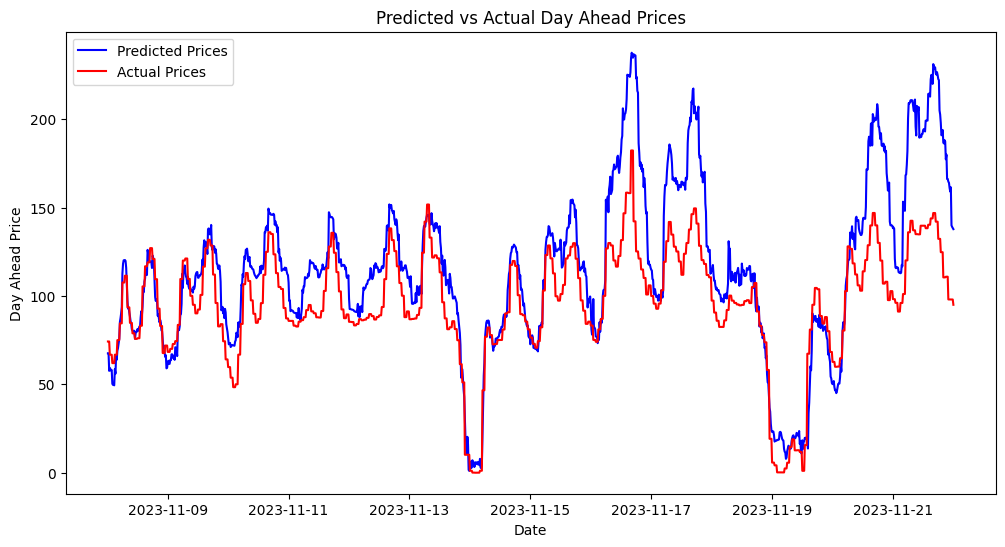

In [60]:
import matplotlib.pyplot as plt

# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_huber= gbr_huber.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_huber, label='Predicted Prices', color='blue')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()
plt.show()


In [63]:
# Best parameters from your previous grid search, with 'huber' loss
best_params_huber = {
    'n_estimators': 300,
    'learning_rate': 0.2,
    'max_depth': 5,
    'loss': 'huber',
    'min_samples_split': 10
}

# Create the model with 'huber' loss
gbr_huber_2 = GradientBoostingRegressor(**best_params_huber, random_state=42)

# Training the model
gbr_huber_2.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred_huber_2 = gbr_huber_2.predict(X_test_scaled)

# Evaluating the model
mae_huber_2 = mean_absolute_error(y_test, y_pred_huber_2)
mse_huber_2 = mean_squared_error(y_test, y_pred_huber_2)
r2_huber_2 = r2_score(y_test, y_pred_huber_2)

# Displaying the evaluation metrics
print("Mean Absolute Error with 'huber' loss:", mae_huber_2)
print("Mean Squared Error with 'huber' loss:", mse_huber_2)
print("R² Score with 'huber' loss:", r2_huber_2)


Mean Absolute Error with 'huber' loss: 6.294109655257876
Mean Squared Error with 'huber' loss: 126.98442942135942
R² Score with 'huber' loss: 0.9872984008471815


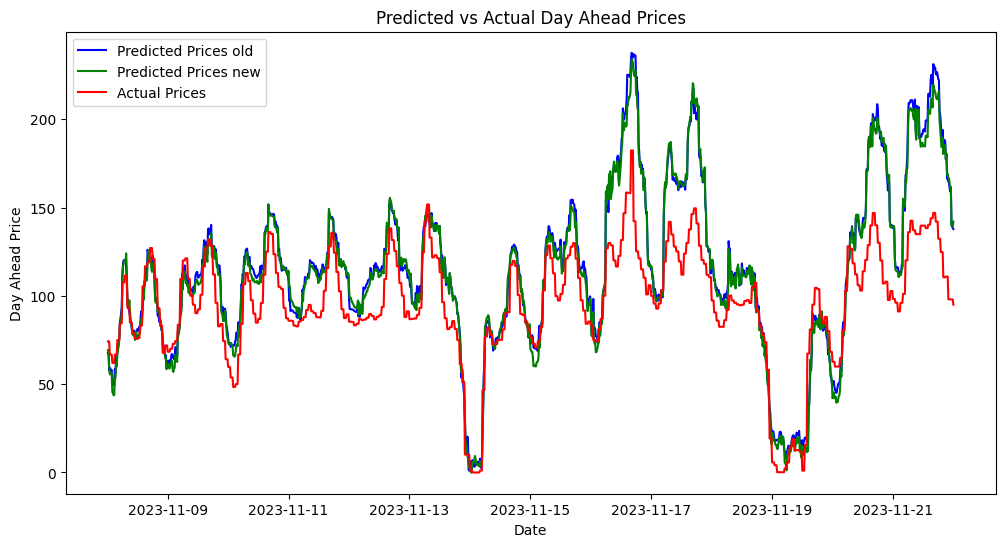

In [64]:
# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_huber_2= gbr_huber_2.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_huber, label='Predicted Prices old', color='blue')
plt.plot(last_two_weeks_data.index, predicted_prices_huber_2, label='Predicted Prices new', color='green')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()
plt.show()


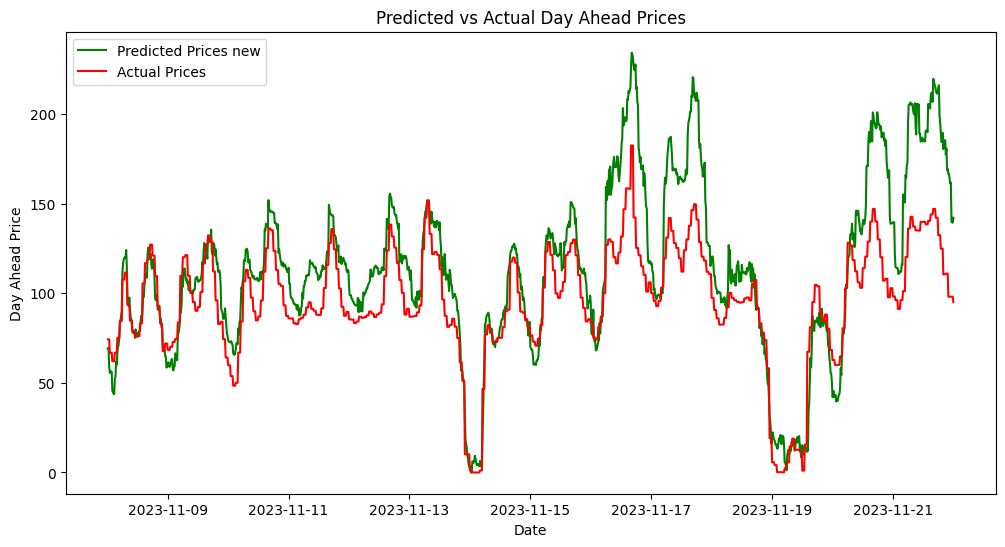

In [65]:
# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_huber_2, label='Predicted Prices new', color='green')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()
plt.show()


In [66]:
# Best parameters from your previous grid search, with 'huber' loss
best_params_huber = {
    'n_estimators': 300,
    'learning_rate': 0.1,
    'max_depth': 5,
    'loss': 'huber',
    'min_samples_split': 10
}

# Create the model with 'huber' loss
gbr_huber_3 = GradientBoostingRegressor(**best_params_huber, random_state=42)

# Training the model
gbr_huber_3.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred_huber_3 = gbr_huber_3.predict(X_test_scaled)

# Evaluating the model
mae_huber_3 = mean_absolute_error(y_test, y_pred_huber_3)
mse_huber_3 = mean_squared_error(y_test, y_pred_huber_3)
r2_huber_3 = r2_score(y_test, y_pred_huber_3)

# Displaying the evaluation metrics
print("Mean Absolute Error with 'huber' loss:", mae_huber_3)
print("Mean Squared Error with 'huber' loss:", mse_huber_3)
print("R² Score with 'huber' loss:", r2_huber_3)


Mean Absolute Error with 'huber' loss: 7.166395414192238
Mean Squared Error with 'huber' loss: 168.63313128320925
R² Score with 'huber' loss: 0.9831324954783499


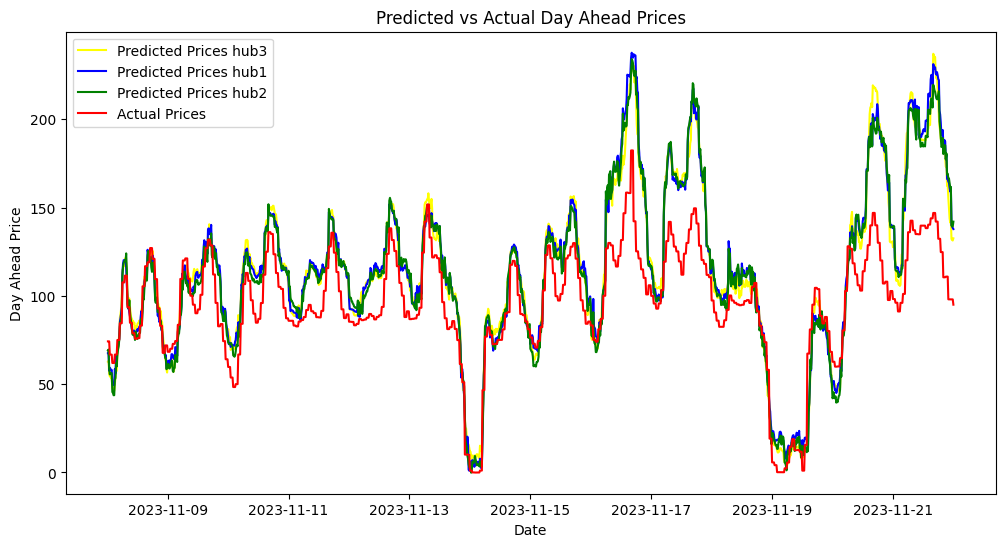

In [67]:
# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_huber_3= gbr_huber_3.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_huber_3, label='Predicted Prices hub3', color='yellow')
plt.plot(last_two_weeks_data.index, predicted_prices_huber, label='Predicted Prices hub1', color='blue')
plt.plot(last_two_weeks_data.index, predicted_prices_huber_2, label='Predicted Prices hub2', color='green')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()


In [68]:
# Best parameters from your previous grid search, with 'huber' loss
best_params_huber = {
    'n_estimators': 300,
    'learning_rate': 0.2,
    'max_depth': 8,
    'loss': 'huber',
    'min_samples_split': 10
}

# Create the model with 'huber' loss
gbr_huber_3_depth = GradientBoostingRegressor(**best_params_huber, random_state=42)

# Training the model
gbr_huber_3_depth.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred_huber_3_depth = gbr_huber_3_depth.predict(X_test_scaled)

# Evaluating the model
mae_huber_3_depth = mean_absolute_error(y_test, y_pred_huber_3_depth)
mse_huber_3_depth = mean_squared_error(y_test, y_pred_huber_3_depth)
r2_huber_3_depth = r2_score(y_test, y_pred_huber_3_depth)

# Displaying the evaluation metrics
print("Mean Absolute Error with 'huber' loss:", mae_huber_3_depth)
print("Mean Squared Error with 'huber' loss:", mse_huber_3_depth)
print("R² Score with 'huber' loss:", r2_huber_3_depth)


Mean Absolute Error with 'huber' loss: 4.109854305824863
Mean Squared Error with 'huber' loss: 62.058401337180435
R² Score with 'huber' loss: 0.9937926173985153


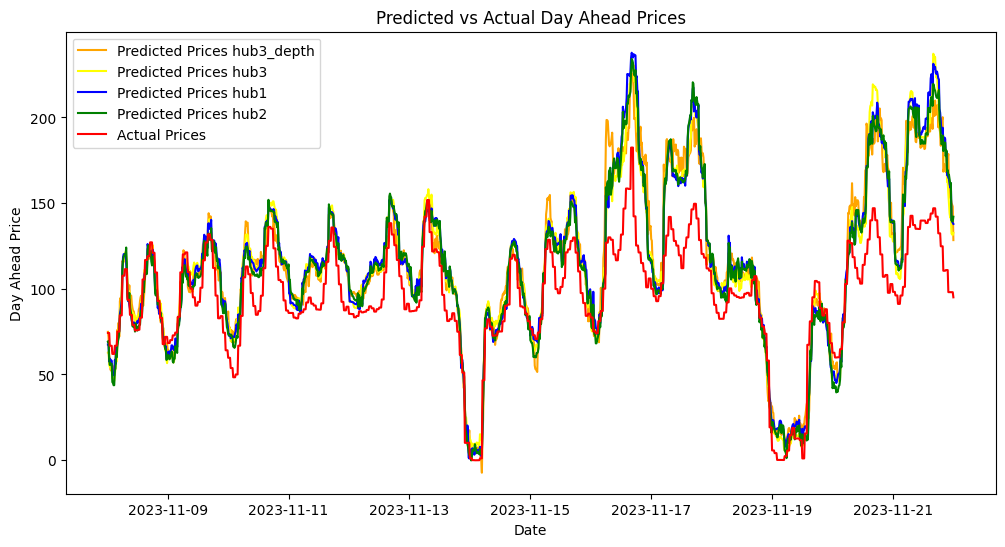

In [69]:
# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_huber_3_depth= gbr_huber_3_depth.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_huber_3_depth, label='Predicted Prices hub3_depth', color='orange')
plt.plot(last_two_weeks_data.index, predicted_prices_huber_3, label='Predicted Prices hub3', color='yellow')
plt.plot(last_two_weeks_data.index, predicted_prices_huber, label='Predicted Prices hub1', color='blue')
plt.plot(last_two_weeks_data.index, predicted_prices_huber_2, label='Predicted Prices hub2', color='green')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()


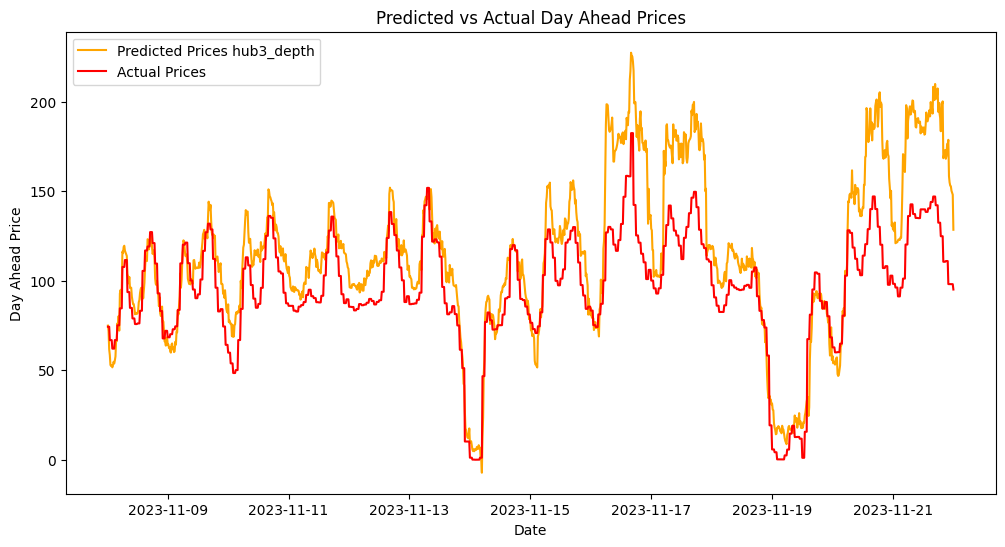

In [70]:
# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_huber_3_depth= gbr_huber_3_depth.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_huber_3_depth, label='Predicted Prices hub3_depth', color='orange')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()


In [71]:
# Best parameters from your previous grid search, with 'huber' loss
best_params_huber = {
    'n_estimators': 300,
    'learning_rate': 0.2,
    'max_depth': 12,
    'loss': 'huber',
    'min_samples_split': 10
}

# Create the model with 'huber' loss
gbr_huber_3_depth2 = GradientBoostingRegressor(**best_params_huber, random_state=42)

# Training the model
gbr_huber_3_depth2.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred_huber_3_depth2 = gbr_huber_3_depth2.predict(X_test_scaled)

# Evaluating the model
mae_huber_3_depth2 = mean_absolute_error(y_test, y_pred_huber_3_depth2)
mse_huber_3_depth2 = mean_squared_error(y_test, y_pred_huber_3_depth2)
r2_huber_3_depth2 = r2_score(y_test, y_pred_huber_3_depth2)

# Displaying the evaluation metrics
print("Mean Absolute Error with 'huber' loss:", mae_huber_3_depth2)
print("Mean Squared Error with 'huber' loss:", mse_huber_3_depth2)
print("R² Score with 'huber' loss:", r2_huber_3_depth2)


Mean Absolute Error with 'huber' loss: 3.0117772876411846
Mean Squared Error with 'huber' loss: 42.27641982633673
R² Score with 'huber' loss: 0.995771307232727


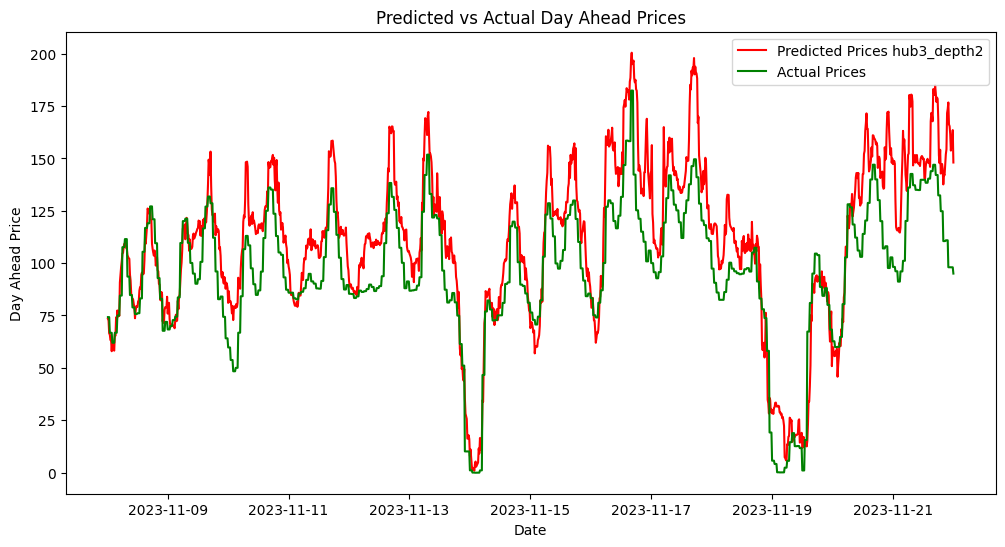

In [76]:
# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_huber_3_depth2= gbr_huber_3_depth2.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_huber_3_depth2, label='Predicted Prices hub3_depth2', color='red')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='green')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()


Mean Absolute Error: 8.233426329899618
Mean Squared Error: 186.67519109529246
R² Score: 0.981327841059942


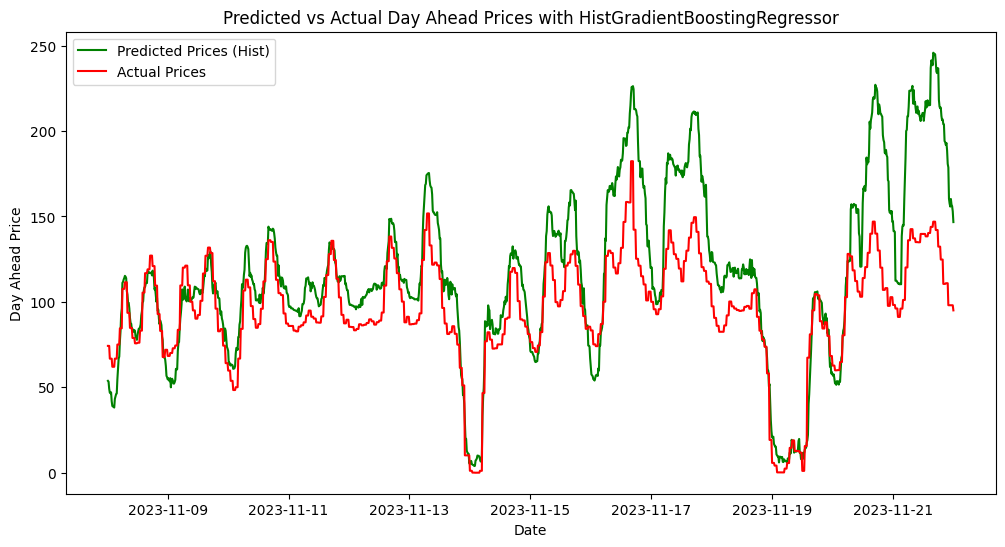

In [75]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
import matplotlib.pyplot as plt

# Best parameters adapted for HistGradientBoostingRegressor
best_params_hist = {
    'max_iter': 300,
    'learning_rate': 0.1,
    'max_depth': 4,
    # 'loss': 'auto',  # Default is 'auto', which is least squares regression
    # Additional parameters can be added here if needed
}

# Create the HistGradientBoostingRegressor model
hist_gbr = HistGradientBoostingRegressor(**best_params_hist, random_state=42)

# Training the model
hist_gbr.fit(X_train_scaled, y_train)

# Predicting and evaluating the model
y_pred_hist = hist_gbr.predict(X_test_scaled)
mae_hist = mean_absolute_error(y_test, y_pred_hist)
mse_hist = mean_squared_error(y_test, y_pred_hist)
r2_hist = r2_score(y_test, y_pred_hist)

# Displaying the evaluation metrics
print("Mean Absolute Error:", mae_hist)
print("Mean Squared Error:", mse_hist)
print("R² Score:", r2_hist)

# Predicting the 'day_ahead_price' for the last two weeks
predicted_prices_hist = hist_gbr.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_hist, label='Predicted Prices (Hist)', color='green')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices with HistGradientBoostingRegressor')
plt.legend()
plt.show()


In [77]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'max_iter': [100, 200, 300],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 10],
     'min_samples_leaf': [20, 40, 60],  # Uncomment if you want to include this parameter
    # Additional parameters can be added here
}

# Create the GridSearchCV object
hist_gbr = HistGradientBoostingRegressor(random_state=42)
grid_search = GridSearchCV(hist_gbr, param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit GridSearchCV to the training data
grid_search.fit(X_train_scaled, y_train)

# Extract the best parameters and model
best_params = grid_search.best_params_
best_hist_gbr = grid_search.best_estimator_

# Optionally: Evaluate the best model
y_pred_best = best_hist_gbr.predict(X_test_scaled)
best_mae = mean_absolute_error(y_test, y_pred_best)
best_mse = mean_squared_error(y_test, y_pred_best)
best_r2 = r2_score(y_test, y_pred_best)

# Display the best parameters and evaluation metrics
print("Best Parameters:", best_params)
print("Best Model Mean Absolute Error:", best_mae)
print("Best Model Mean Squared Error:", best_mse)
print("Best Model R² Score:", best_r2)


Fitting 5 folds for each of 81 candidates, totalling 405 fits
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=40; total time=   7.9s
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=40; total time=   7.9s
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=20; total time=   7.9s
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=20; total time=   7.9s
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=20; total time=   9.5s
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=40; total time=   9.5s
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=20; total time=   9.5s
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=20; total time=   9.4s
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=40; total time=   7.5s
[CV] END learning_rate=0.01, max_depth=3, max_iter=100, min_samples_leaf=4

In [78]:
from sklearn.model_selection import cross_val_score

# Best parameters from your grid search
best_params = {
    'learning_rate': 0.2,
    'max_depth': 10,
    'max_iter': 300,
    'min_samples_leaf': 20
}

# Creating the HistGradientBoostingRegressor model with the best parameters
best_hist_gbr = HistGradientBoostingRegressor(**best_params, random_state=42)

# Perform cross-validation
cv_scores_mae = cross_val_score(best_hist_gbr, X_train_scaled, y_train, cv=5, scoring='neg_mean_absolute_error')
cv_scores_mse = cross_val_score(best_hist_gbr, X_train_scaled, y_train, cv=5, scoring='neg_mean_squared_error')
cv_scores_r2 = cross_val_score(best_hist_gbr, X_train_scaled, y_train, cv=5, scoring='r2')

# The scores are negated to follow the convention that higher is better (as sklearn's scoring is a utility function)
mean_mae = -cv_scores_mae.mean()
mean_mse = -cv_scores_mse.mean()
mean_r2 = cv_scores_r2.mean()

# Displaying the cross-validation results
print("Cross-validated Mean Absolute Error:", mean_mae)
print("Cross-validated Mean Squared Error:", mean_mse)
print("Cross-validated R² Score:", mean_r2)


Cross-validated Mean Absolute Error: 5.672304501740911
Cross-validated Mean Squared Error: 83.4859394164029
Cross-validated R² Score: 0.9918453997560663


Mean Absolute Error: 5.562831835763622
Mean Squared Error: 78.89887732538561
R² Score: 0.9921081512279813


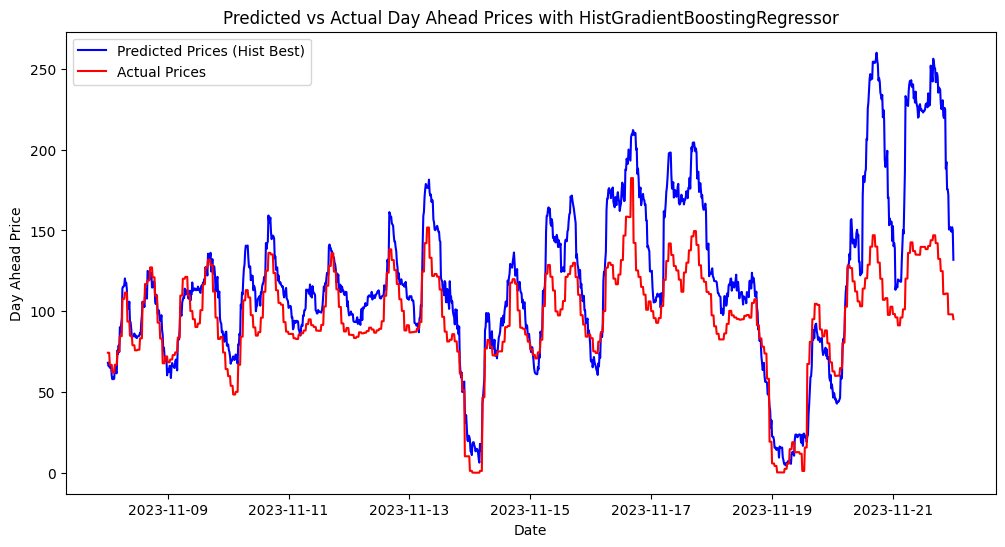

In [79]:
from sklearn.experimental import enable_hist_gradient_boosting  # noqa
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Best parameters from your grid search
best_params_hist = {
    'max_iter': 300,  # Equivalent to 'n_estimators'
    'learning_rate': 0.2,
    'max_depth': 10,
    'min_samples_leaf': 20  # Note: 'min_samples_split' is not available in HistGradientBoostingRegressor
}

# Create the HistGradientBoostingRegressor model with the best parameters
hist_gbr_best = HistGradientBoostingRegressor(**best_params_hist, random_state=42)

# Training the model
hist_gbr_best.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred_hist_best = hist_gbr_best.predict(X_test_scaled)

# Evaluating the model
mae_hist_best = mean_absolute_error(y_test, y_pred_hist_best)
mse_hist_best = mean_squared_error(y_test, y_pred_hist_best)
r2_hist_best = r2_score(y_test, y_pred_hist_best)

# Displaying the evaluation metrics
print("Mean Absolute Error:", mae_hist_best)
print("Mean Squared Error:", mse_hist_best)
print("R² Score:", r2_hist_best)

# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_hist_best = hist_gbr_best.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_hist_best, label='Predicted Prices (Hist Best)', color='blue')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='red')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices with HistGradientBoostingRegressor')
plt.legend()
plt.show()


Mean Absolute Error with 'huber' loss: 3.035015502110797
Mean Squared Error with 'huber' loss: 42.24663741809924
R² Score with 'huber' loss: 0.9957742862137954


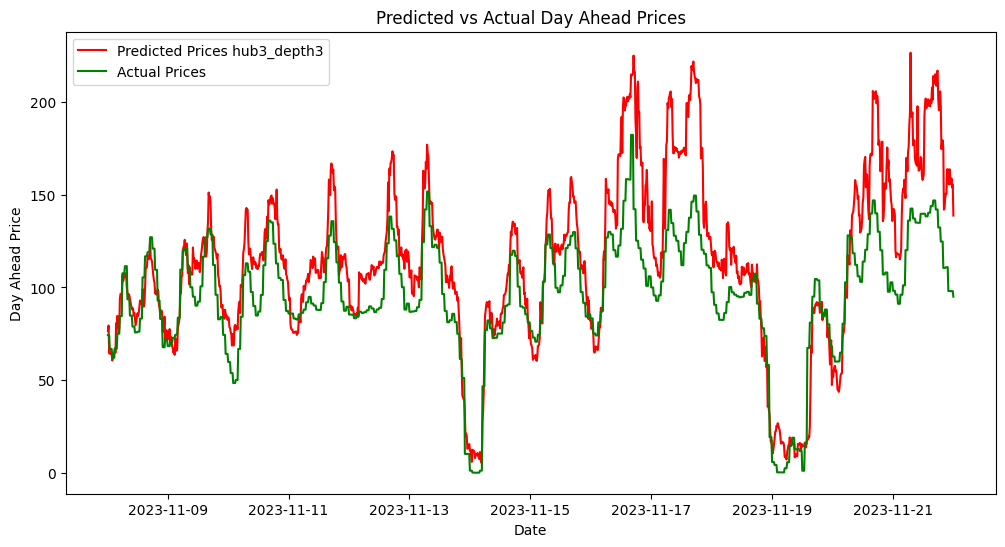

In [80]:
# Best parameters from your previous grid search, with 'huber' loss
best_params_huber = {
    'n_estimators': 300,
    'learning_rate': 0.2,
    'max_depth': 12,
    'loss': 'huber',
    'min_samples_split': 14
}

# Create the model with 'huber' loss
gbr_huber_3_depth3 = GradientBoostingRegressor(**best_params_huber, random_state=42)

# Training the model
gbr_huber_3_depth3.fit(X_train_scaled, y_train)

# Predicting the target values for the test set
y_pred_huber_3_depth3 = gbr_huber_3_depth3.predict(X_test_scaled)

# Evaluating the model
mae_huber_3_depth3 = mean_absolute_error(y_test, y_pred_huber_3_depth3)
mse_huber_3_depth3 = mean_squared_error(y_test, y_pred_huber_3_depth3)
r2_huber_3_depth3 = r2_score(y_test, y_pred_huber_3_depth3)

# Displaying the evaluation metrics
print("Mean Absolute Error with 'huber' loss:", mae_huber_3_depth3)
print("Mean Squared Error with 'huber' loss:", mse_huber_3_depth3)
print("R² Score with 'huber' loss:", r2_huber_3_depth3)

# Preprocessing the 'last_two_weeks_data'
X_last_two_weeks = last_two_weeks_data.drop(columns=['day_ahead_price'])
X_last_two_weeks_scaled = preprocessor.transform(X_last_two_weeks)

# Predicting the 'day_ahead_price'
predicted_prices_huber_3_depth3= gbr_huber_3_depth3.predict(X_last_two_weeks_scaled)

# Plotting Predictions vs Actual Values
plt.figure(figsize=(12, 6))
plt.plot(last_two_weeks_data.index, predicted_prices_huber_3_depth3, label='Predicted Prices hub3_depth3', color='red')
plt.plot(last_two_weeks_data.index, last_two_weeks_data['day_ahead_price'], label='Actual Prices', color='green')
plt.xlabel('Date')
plt.ylabel('Day Ahead Price')
plt.title('Predicted vs Actual Day Ahead Prices')
plt.legend()
